<a href="https://colab.research.google.com/github/AmrMomtaz/Image-Mosaics/blob/main/Image_Mosaics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Mosaics**

In [ ]:
# Importing libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

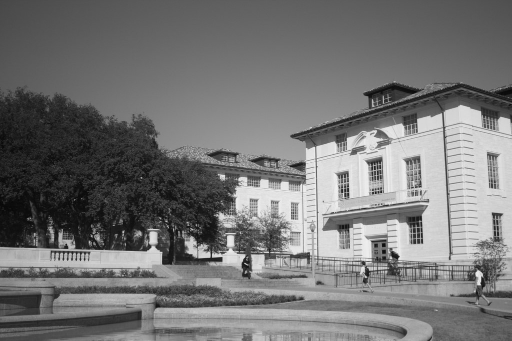

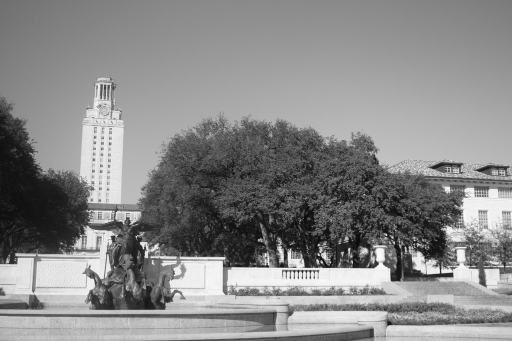

In [ ]:
# Loading and resisizing images (Images must be loaded in /content directory)
img1 = cv2.imread('/content/pano_image1.jpg')
img1_grey = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('/content/pano_image2.jpg')
img2_grey = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1 = cv2.resize(img1, (int(img1.shape[1]/2), int(img1.shape[0]/2)))
img2 = cv2.resize(img2, (int(img2.shape[1]/2), int(img2.shape[0]/2)))
img1_grey = cv2.resize(img1_grey, (int(img1_grey.shape[1]/2), 
                                   int(img1_grey.shape[0]/2)))
img2_grey = cv2.resize(img2_grey, (int(img2_grey.shape[1]/2), 
                                   int(img2_grey.shape[0]/2)))
cv2_imshow(img1_grey)
print()
cv2_imshow(img2_grey)

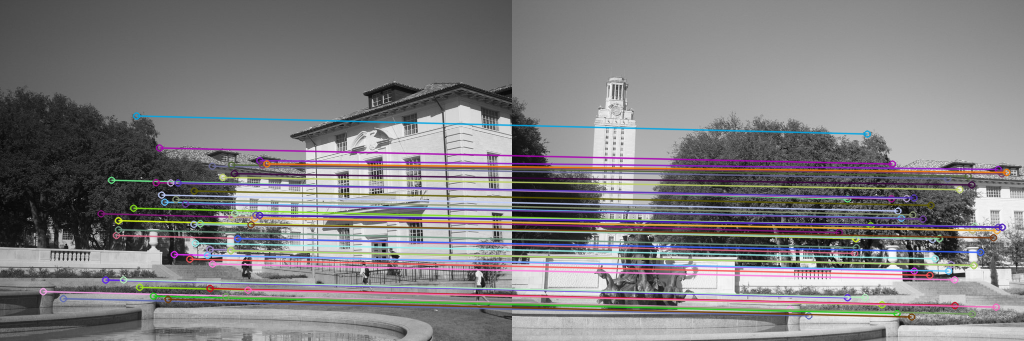


Number of matched points = 50


In [ ]:
# Getting the correspondences
# Best threshold 0.205 for full image and 0.297 for half size
def get_correspondences(img1_grey, img2_grey, THRESHOLD):
  # Step 1: Getting the SIFT descriptor for each image
  # https://amroamroamro.github.io/mexopencv/matlab/cv.SIFT.detectAndCompute.html
  sift = cv2.xfeatures2d.SIFT_create()
  kp1, src = sift.detectAndCompute(img1_grey, None)
  kp2, dst = sift.detectAndCompute(img2_grey, None)

  # Step 2: Getting matches
  BFMatcher = cv2.BFMatcher()
  matches = BFMatcher.knnMatch(src, dst, k=2)

  # Step 3: Filtering matched to get the best
  matched_points = list()
  best_matches = list()

  for (match1, match2) in matches:
    if match1.distance / match2.distance < THRESHOLD:
      (x1, y1) = kp1[match1.queryIdx].pt
      (x2, y2) = kp2[match1.trainIdx].pt
      matched_points.append([x1, y1, x2, y2])
      best_matches.append(match1)
  matched_points = np.array(matched_points)
  cv2_imshow(cv2.drawMatches(img1_grey, kp1, img2_grey, kp2, best_matches, None, 
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
  return matched_points
  
matched_points = get_correspondences(img1_grey, img2_grey, 0.297)
print(f'\nNumber of matched points = {matched_points.shape[0]}')

In [ ]:
# Calculating the homography using dlt
def calculate_homography(matched_points):
    A = list()
    for point in matched_points:
      x1 = point[0]
      y1 = point[1]
      x2 = point[2]
      y2 = point[3]
      row1 = np.array([-x1, -y1, -1, 0, 0, 0, x1 * x2, y1 * x2, x2])
      row2 = np.array([0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2])
      A.append(row1)
      A.append(row2)
    U,S,V = np.linalg.svd(A)
    H = V[8]
    H = np.array(H)
    H = H.reshape((3,3))
    H = H/H[2, 2] # Normalizing so that H[2,2] = 1
    return H
H = calculate_homography(matched_points)
print(f'The calulated H:\n{H}\nThe Best H:\n'
      + f'{cv2.findHomography(matched_points[:,:2], matched_points[:,2:])[0]}')

The calulated H:
[[ 7.57746283e-01  3.39133943e-02  2.24263487e+02]
 [-1.36983217e-01  9.07053044e-01  3.86199308e+01]
 [-4.29771868e-04 -7.22601953e-05  1.00000000e+00]]
The Best H:
[[ 7.61983731e-01  3.71103769e-02  2.23765623e+02]
 [-1.36069947e-01  9.11218799e-01  3.81052701e+01]
 [-4.25382657e-04 -6.51474237e-05  1.00000000e+00]]


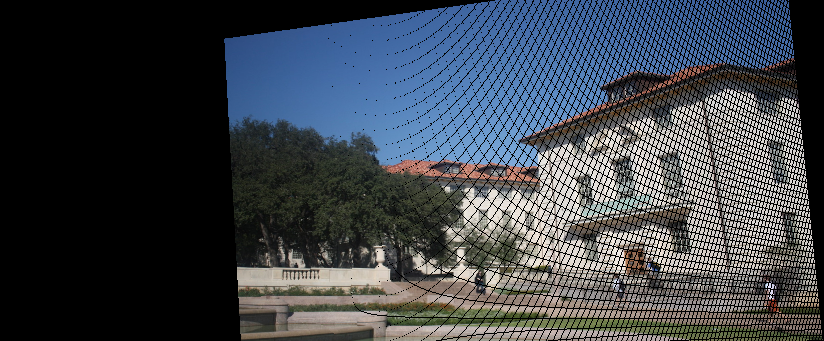

In [ ]:
# Forward warping only

def forward_warp(src_img, H):
  n = src_img.shape[0]; m = src_img.shape[1]
  original_boundries = [[0,0,1], [0,n-1,1], [m-1,0,1], [m-1,n-1,1]]
  new_boundries = list()
  for boundry in original_boundries:
    boundry = np.dot(H, boundry)
    boundry = np.round(boundry/boundry[2])
    new_boundries.append(boundry)

  x = sorted([boundry[0] for boundry in new_boundries])
  y = sorted([boundry[1] for boundry in new_boundries])
  new_h = round(y[-1] - y[0]); new_w = round(x[-1] - x[0]); corner = int(x[-1])
  warped_img = np.zeros((src_img.shape[0] + 100, corner, 3))
  for i in range(0, new_w):
    for j in range(0, new_h):
      point = np.matmul(H, [i,j,1])
      point = np.round(point / point[2])
      x = int(point[1])
      y = int(point[0])
      try:
        warped_img[x, y, 0] = src_img[j,i,0]
        warped_img[x, y, 1] = src_img[j,i,1]
        warped_img[x, y, 2] = src_img[j,i,2]
      except:
        None
  warped_img = warped_img[:src_img.shape[0], :corner, :]
  return warped_img

warped_img = forward_warp(img1, H)
cv2_imshow(warped_img)

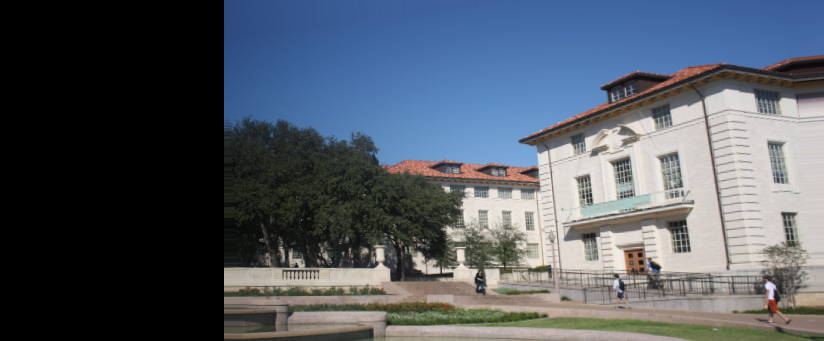

In [ ]:
# Warping images

'''
Performs Bi-linear interpolation
'''
def interpolate(point, src_img):
  x = point[1]
  y = point[0]
  if x < 0:
    x = 0
  if y < 0:
    y = 0
  if x >= src_img.shape[0]-1:
    x = src_img.shape[0] - 2
  if y >= src_img.shape[1]-1:
    y = src_img.shape[1] - 2
  boarders = [(int(x),int(y)),(int(x)+1,int(y)),(int(x),int(y)+1),
              (int(x)+1,int(y)+1)]
  weights = list()
  for boarder in boarders:
    weights.append((1-abs(x-boarder[0])) * (1-abs(y-boarder[1])))
  result = 0
  for i in range(len(boarders)):
    boarder = boarders[i]
    result += src_img[boarder[0],boarder[1]]*weights[i]
  return int(result)

'''
Gets the new boundries performing forward warping
'''
def get_new_boundaries(H, n, m):
  original_boundries = [[0,0,1], [0,n-1,1], [m-1,0,1], [m-1,n-1,1]]
  new_boundries = list()
  for boundry in original_boundries:
    boundry = np.dot(H, boundry)
    boundry = np.round(boundry/boundry[2])
    # Limit the size of the output image height to the original images height
    boundry[1] = max(0, boundry[1])
    boundry[1] = min(boundry[1], n)
    new_boundries.append(boundry)
  return new_boundries

'''
Fills the new boundries using inverse warping and interpolation.
'''
def warp_image(src_img, H, min_x, min_y, new_h, new_w, corner):
  H_inv = np.linalg.inv(H)
  warped_img = np.zeros((src_img.shape[0], corner, 3))  
  for i in range(int(min_x), int(min_x + new_w)):
    for j in range(int(min_y), int(min_y + new_h)):
      point = np.matmul(H_inv, [i,j,1])
      point /= point[2]
      warped_img[j, i, 0] = interpolate(point, src_img[:,:,0])
      warped_img[j, i, 1] = interpolate(point, src_img[:,:,1])
      warped_img[j, i, 2] = interpolate(point, src_img[:,:,2])
  return warped_img

def perform_warping(H, src):
  # Getting the new image boundries using forward warping
  new_boundries = get_new_boundaries(H, src.shape[0], src.shape[1])
  
  x = sorted([boundry[0] for boundry in new_boundries])
  y = sorted([boundry[1] for boundry in new_boundries])
  min_x = x[0]; min_y = y[0]
  new_h = round(y[-1] - min_y); new_w = round(x[-1] - min_x)
  return warp_image(src, H, min_x, min_y, new_h, new_w, int(x[-1]))

warped_img = perform_warping(H, img1)
cv2_imshow(warped_img)

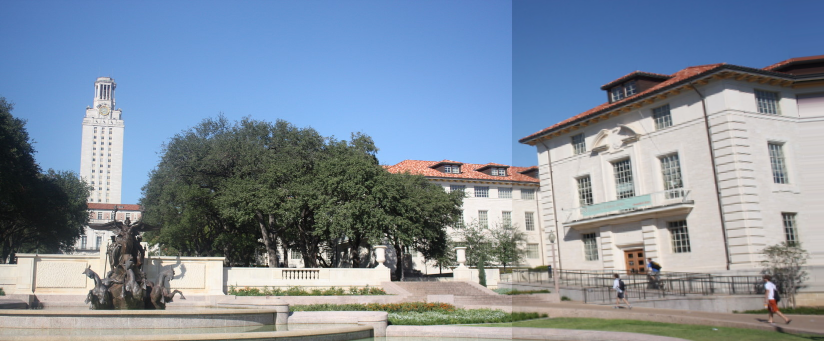

In [ ]:
# Stitching the two images
stitched_img = warped_img.copy()
stitched_img[0: img2.shape[0], 0: img2.shape[1]] = img2 
cv2_imshow(stitched_img)

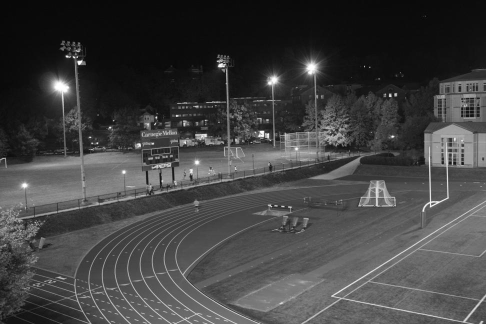

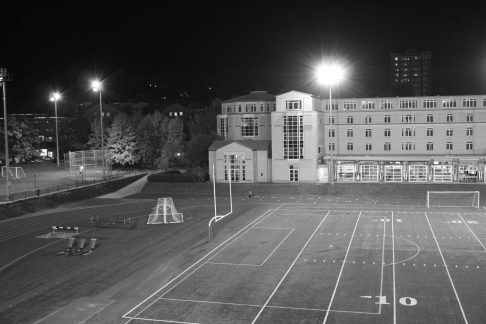

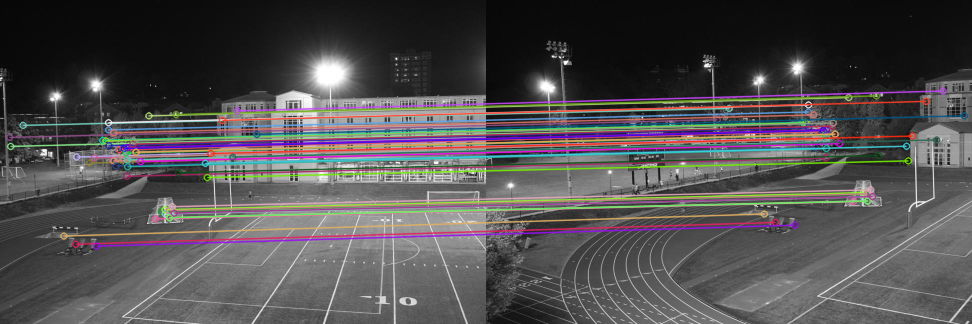


Number of matched points = 50
The calulated H:
[[ 7.56798230e-01 -3.38066888e-03  2.24727153e+02]
 [-6.25752430e-02  9.43047475e-01 -9.23599933e+00]
 [-5.09776401e-04  4.39804083e-05  1.00000000e+00]]
The Best H:
[[ 7.56967540e-01 -3.08632675e-03  2.24708357e+02]
 [-6.25368057e-02  9.43414691e-01 -9.27890318e+00]
 [-5.09587528e-04  4.47307520e-05  1.00000000e+00]]


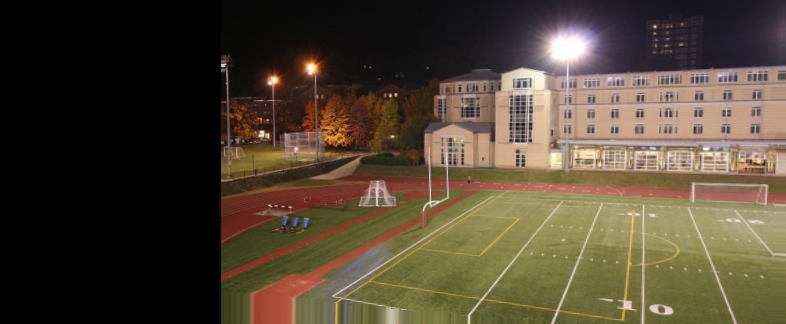

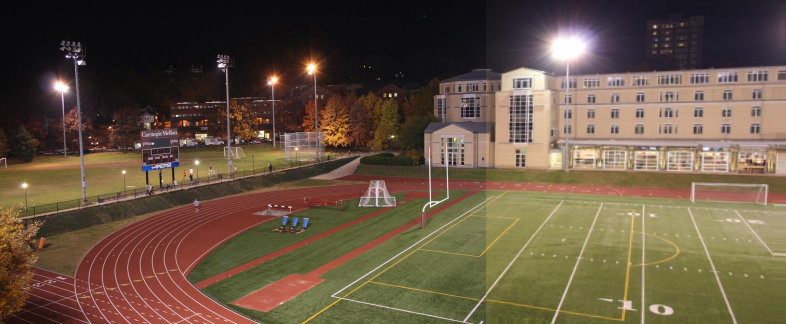

In [ ]:
# Loading images
img1 = cv2.imread('/content/im89.jpg')
img1_grey = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('/content/im90.jpg')
img2_grey = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1 = cv2.resize(img1, (int(img1.shape[1]/2), int(img1.shape[0]/2)))
img2 = cv2.resize(img2, (int(img2.shape[1]/2), int(img2.shape[0]/2)))
img1_grey = cv2.resize(img1_grey, (int(img1_grey.shape[1]/2), 
                                   int(img1_grey.shape[0]/2)))
img2_grey = cv2.resize(img2_grey, (int(img2_grey.shape[1]/2), 
                                   int(img2_grey.shape[0]/2)))
cv2_imshow(img1_grey)
cv2_imshow(img2_grey)
# Getting the correspondences
matched_points = get_correspondences(img2_grey, img1_grey, 0.2215)
print(f'\nNumber of matched points = {matched_points.shape[0]}')
# Calculating the homography using dlt
H = calculate_homography(matched_points)
print(f'The calulated H:\n{H}\nThe Best H:\n'
      + f'{cv2.findHomography(matched_points[:,:2], matched_points[:,2:])[0]}')
# Warping images
warped_img = perform_warping(H, img2)
cv2_imshow(warped_img)
# Stitching the two images
stitched_img = warped_img.copy()
stitched_img[0: img1.shape[0], 0: img1.shape[1]] = img1 
cv2_imshow(stitched_img)

### Stitching Three Images Together

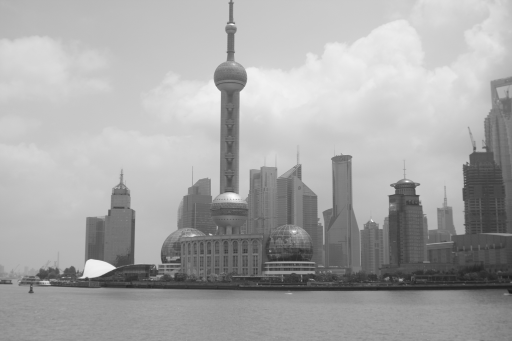

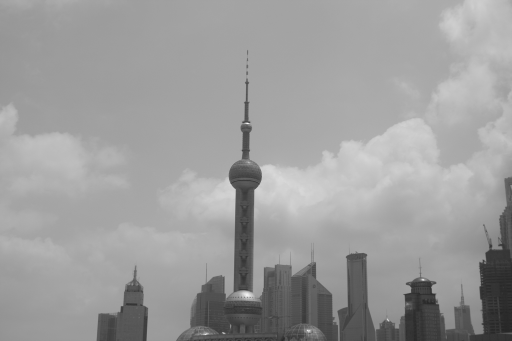

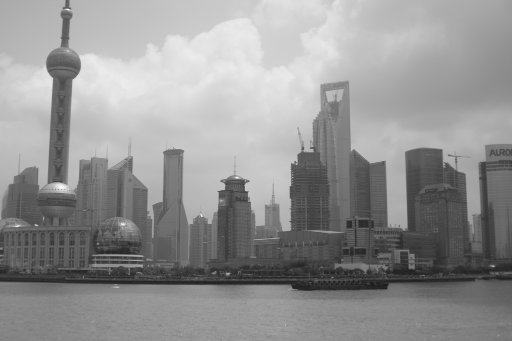

In [ ]:
# Loading and resisizing images (Images must be loaded in /content directory)
img1 = cv2.cvtColor(cv2.imread('/content/shanghai-21.png'),
                         cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread('/content/shanghai-22.png'),
                         cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(cv2.imread('/content/shanghai-23.png'),
                         cv2.COLOR_BGR2GRAY)
img1 = cv2.resize(img1, (int(img1.shape[1]/2), int(img1.shape[0]/2)))
img2 = cv2.resize(img2, (int(img2.shape[1]/2), int(img2.shape[0]/2)))
img3 = cv2.resize(img3, (int(img3.shape[1]/2), int(img3.shape[0]/2)))
cv2_imshow(img1)
print()
cv2_imshow(img2)
print()
cv2_imshow(img3)

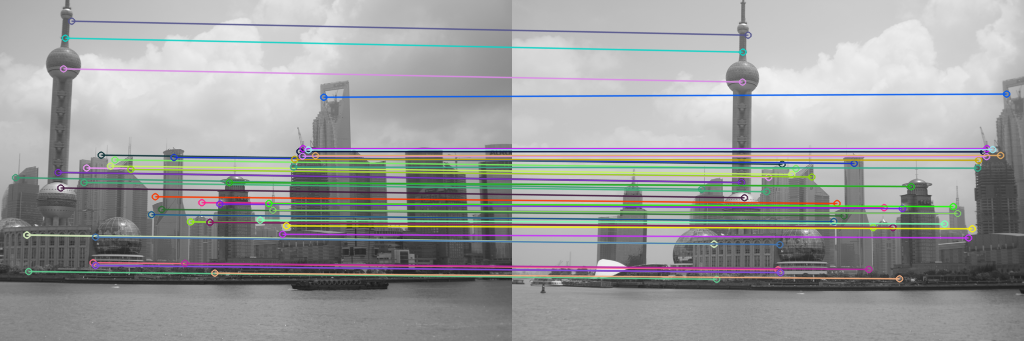


Number of matched points = 50


In [ ]:
# Getting correspondences
matched_points = get_correspondences(img3, img1, 0.2164)
print(f'\nNumber of matched points = {matched_points.shape[0]}')

In [ ]:
# Calculating the homography using dlt
H = calculate_homography(matched_points)
print(f'The calulated H:\n{H}\nThe Best H:\n'
      + f'{cv2.findHomography(matched_points[:,:2], matched_points[:,2:])[0]}')

The calulated H:
[[ 8.83474386e-01  3.29442027e-02  1.68742964e+02]
 [-7.68278003e-02  9.54572590e-01  1.96775877e+01]
 [-2.26912324e-04 -1.44618921e-05  1.00000000e+00]]
The Best H:
[[ 8.83681723e-01  3.31812090e-02  1.68724860e+02]
 [-7.68468479e-02  9.54973534e-01  1.96418694e+01]
 [-2.26710341e-04 -1.37035962e-05  1.00000000e+00]]


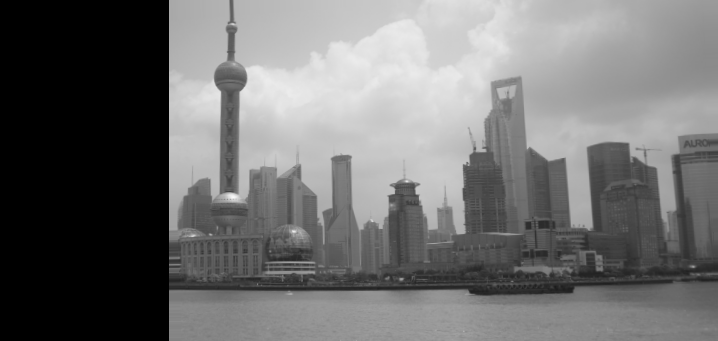

In [ ]:
# Warping images
def warp_image(src_img, H, min_x, min_y, new_h, new_w, corner):
  H_inv = np.linalg.inv(H)
  warped_img = np.zeros((src_img.shape[0], corner))  
  for i in range(int(min_x), int(min_x + new_w)):
    for j in range(int(min_y), int(min_y + new_h)):
      point = np.matmul(H_inv, [i,j,1])
      point /= point[2]
      warped_img[j, i] = interpolate(point, src_img)
  return warped_img

warped_img = perform_warping(H, img3)
cv2_imshow(warped_img)

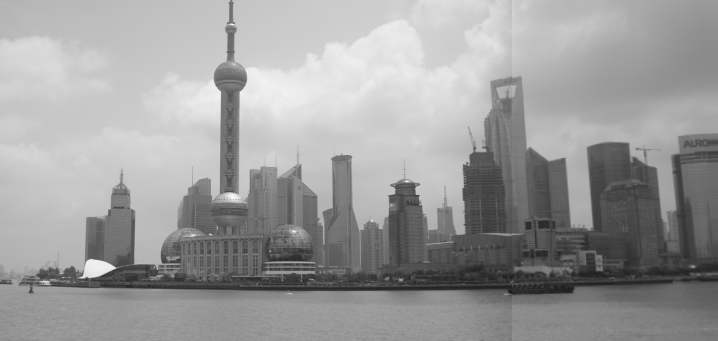

In [ ]:
# Stitching the two images
stitched_img = warped_img.copy()
stitched_img[:img1.shape[0], :img1.shape[1]] = img1
stitched_img = stitched_img.astype('uint8')
cv2_imshow(stitched_img)

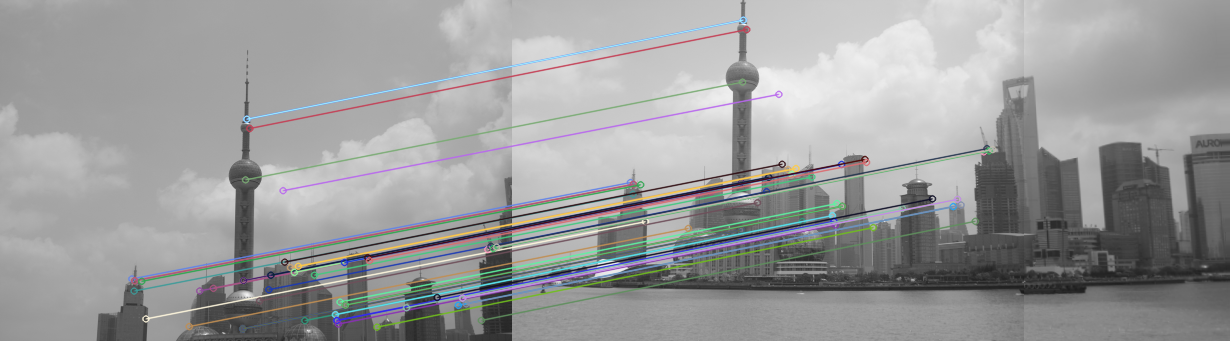


Number of matched points = 50


In [ ]:
# Getting correspondences
matched_points = get_correspondences(img2, stitched_img, 0.268)
print(f'\nNumber of matched points = {matched_points.shape[0]}')

In [ ]:
# Calculating the homography using dlt
H = calculate_homography(matched_points)
print(f'The calulated H:\n{H}\nThe Best H:\n'
      + f'{cv2.findHomography(matched_points[:,:2], matched_points[:,2:])[0]}')

The calulated H:
[[ 1.05135326e+00  5.10153070e-02 -2.83760338e+01]
 [-9.66691248e-04  1.06798481e+00 -1.06400095e+02]
 [ 2.14203280e-05  1.74846560e-04  1.00000000e+00]]
The Best H:
[[ 1.04902680e+00  4.95233946e-02 -2.78153086e+01]
 [-1.24437152e-03  1.06546615e+00 -1.05964965e+02]
 [ 2.00682813e-05  1.69546274e-04  1.00000000e+00]]


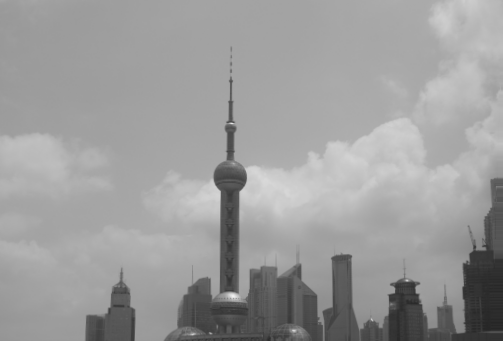

In [ ]:
# Warping images
def get_new_boundaries(H, n, m):
  original_boundries = [[0,0,1], [0,n-1,1], [m-1,0,1], [m-1,n-1,1]]
  new_boundries = list()
  for boundry in original_boundries:
    boundry = np.dot(H, boundry)
    boundry = np.round(boundry/boundry[2])
    new_boundries.append(boundry)
  return new_boundries

def warp_image(src_img, H, min_x, min_y, new_h, new_w, corner):
  H_inv = np.linalg.inv(H)
  warped_img = np.zeros((src_img.shape[0], corner))  
  for i in range(int(min_x), int(min_x + new_w)):
    for j in range(int(min_y), int(min_y + new_h)):
      point = np.matmul(H_inv, [i,j,1])
      point /= point[2]
      warped_img[j, i] = interpolate(point, src_img)
  diff = src_img.shape[0] - int(min_y + new_h)
  new_img = np.zeros(warped_img.shape)
  new_img[diff:,:] = warped_img[:warped_img.shape[0]-diff,:]
  new_img[:diff] = warped_img[warped_img.shape[0]-diff:,:]
  return new_img, diff

warped_img, diff = perform_warping(H, img2)
warped_img = warped_img.astype('uint8')
cv2_imshow(warped_img)

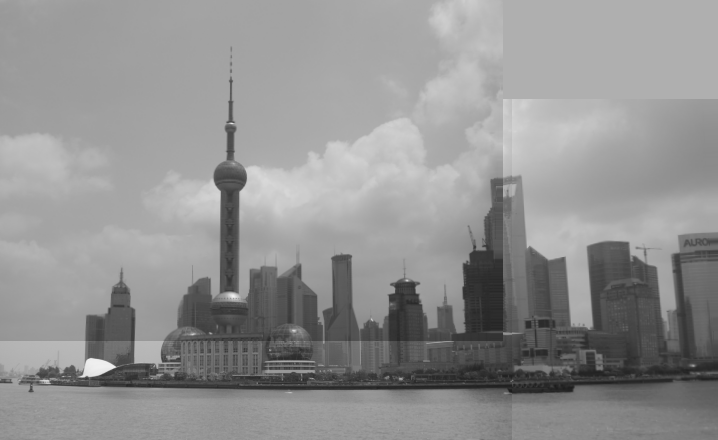

In [ ]:
# Stitching all together
stitched_img_2 = np.empty((stitched_img.shape[0] + diff, stitched_img.shape[1]))\
                   .astype('uint8')
stitched_img_2.fill(175)
stitched_img_2[diff:diff+stitched_img.shape[0],:] = stitched_img
stitched_img_2[:warped_img.shape[0],:warped_img.shape[1]] = warped_img
cv2_imshow(stitched_img_2)